<center><h1 style="font-size: 24px;"><strong>Cities In Maryland</strong></h1></center>
Created by: Jackson Lin, Annie Yang, Andy Ni

### Table of Contents

1. [Introduction](#Introduction)
2. [Imports](#Imports)
3. [Data Collection](#Data-Collection)
4. [Data Processing](#Data-Processing)
5. [Exploratory Analysis & Data Visualization](#Exploratory-Analysis-&-Data-Visualization)
6. [Model: Analysis, Hypothesis Testing, & ML](#Model:-Analysis,-Hypothesis-Testing,-&-ML)
7. [Interpretation: Insight & Policy Decision](#Interpretation:-Insight-&-Policy-Decision)

## Introduction

Finding the perfect place to live in Maryland can be hard for some people, but we're here to make it easier. Our project helps people that are looking to settle down or move to Maryland by considering important stuff like housing costs, job opportunities, and safety.

We will analyize data and give you a clear picture of what housing prices are like across different areas in Maryland. Whether you're dreaming of a cozy suburban home or a modern city apartment. But it's not just about the money or the housing, it's about the community too. We look into things like how much people earn and what job opportunities are available in different neighborhoods. Lastly the most important part is safety. We gather data from trusted sources to show you which areas are considered safer than others, so you can feel secure wherever you choose to live.

## Python Libraries and Tools Used

We will be using Python3 and the following libraries and tools for our project:

- [pandas](https://pandas.pydata.org/): We use pandas for data manipulation and analysis. It provides data structures and tools for reading, cleaning, transforming, and analyzing structured data.

- [numpy](https://numpy.org/): We use numpy for numerical operations. NumPy is a fundamental package for computing in Python, making it easier to deal with large arrays and matrices.

- [matplotlib](https://matplotlib.org/): We use matplotlib for plotting graphs and visualizations. Matplotlib is for creating static, animated, and interactive visualizations in Python. For example graphs in our case. 

- [selenium](https://www.selenium.dev/): We use selenium automating web browsers. Selenium is used for web scraping, testing, and automating web applications. It enables interaction with web pages and extraction of data.

- [webdriver-manager](https://pypi.org/project/webdriver-manager/): We use webdriver for managing web driver instances required by Selenium. Webdriver Manager makes the process of downloading, configuring, and managing web drivers easier for different browsers.

- [selenium.webdriver.common.by](https://www.selenium.dev/selenium/docs/api/py/webdriver/selenium.webdriver.common.by.html): We use selenium for locating elements within a page. Selenium WebDriver provides methods for locating elements within a web page based on different criteria, such as ID, class name, tag name, XPath, and CSS selector.

- [time](https://docs.python.org/3/library/time.html): We use time for timing operations. The time module is a standard Python library for working with time-related functions, providing functions for measuring time intervals, delaying execution, formatting time values, and performing other time-related operations.

Each library or module plays a crucial role in web scraping, data processing, or visualization aspects of our project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time

## Data Collection

For our data collection we will be using the [Maryland State Crime Index](http://www.usa.com/rank/maryland-state--crime-index--city-rank.htm) and scraping data from their website. There is a total of 80 cities being recorded on Maryland State Crime Index and below I will be showing that list. By doing this we utilize Selenium WebDriver to automate browser interactions in Python. We begin by launching a Chrome browser and directing it to a webpage that displays crime index rankings for cities in Maryland. We then identify and extract data from table rows, saving only those with actual information. This extracted text is then structured into a DataFrame using Pandas and we used the first row as headers. 

In [2]:
driver = webdriver.Chrome()

# Navigate to the website
url = "http://www.usa.com/rank/maryland-state--crime-index--city-rank.htm"
driver.get(url)

# Extract rows from the table
rows = driver.find_elements(By.XPATH, "//table//tr")

# Initialize a list to hold all row data
data = []

# Extract data from each row
for row in rows:
    # Extract text from each column in the row
    cols = row.find_elements(By.XPATH, ".//td | .//th")
    row_data = [col.text for col in cols]
    if row_data and any(cell.strip() for cell in row_data):  # Ensure the row has non-empty data
        data.append(row_data)

driver.quit()

# Create DataFrame from the extracted data
if data:
    df = pd.DataFrame(data[1:], columns=data[0])

# Check if the 'City / Population' column exists and split it
if 'City / Population' in df.columns:
    # Split 'City / Population' into 'City' and 'Population'
    df[['City', 'Population']] = df['City / Population'].str.split(' / ', expand=True)
    # Remove the state abbreviation from the city names
    df['City'] = df['City'].str.replace(", MD", "")
    # Drop the original 'City / Population' column
    df.drop(columns=['City / Population'], inplace=True)

# Print the DataFrame to verify changes
print(df)

   Rank Crime Index ▲         City Population
0    1.             0         Luke         91
1    2.            74   Lonaconing      1,149
2    3.           187       Oxford        524
3    4.           222    Brentwood      3,107
4    5.           270    Boonsboro      3,452
..  ...           ...          ...        ...
75  76.         4,186    Baltimore    622,271
76  77.         4,340  Bladensburg      9,371
77  78.         4,397       Elkton     15,673
78  79.         4,683    Salisbury     31,334
79  80.         8,130   Ocean City      7,093

[80 rows x 4 columns]


After obtaining the data from the main page source and initializing the process of gathering data from individual city pages, the next step involves iterating through each city's URL, extracting relevant data, and organizing it for our next few steps. By doing so we would need to 

In [3]:
# Initialize driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("http://www.usa.com/rank/maryland-state--crime-index--city-rank.htm")

# Collecting city URLs
city_links = [link.get_attribute('href') for link in driver.find_elements(By.XPATH, "//table//tr[position()>1]/td[3]/a")]

def extract_city_data(city_url):
    driver.get(city_url)
    time.sleep(2)  # Allow some time for the page to fully load
    
    data = {}
    
    # Use dynamic extraction logic, ensuring to catch the key and value correctly
    details = driver.find_elements(By.XPATH, "//div[@id='content']//table//tr")
    for detail in details:
        key_elements = detail.find_elements(By.XPATH, ".//td[1]")
        value_elements = detail.find_elements(By.XPATH, ".//td[2]")
        if key_elements and value_elements:
            key = key_elements[0].text.strip().rstrip(':')
            value = value_elements[0].text.strip()
            data[key] = value

    return data

# Dictionary to store all city data
all_city_data = []

# Iterate over the first ten city URLs
for link in city_links: 
    city_data = extract_city_data(link)
    city_data['URL'] = link
    all_city_data.append(city_data)

# Convert to DataFrame
df2 = pd.DataFrame(all_city_data)

# Optionally, save the DataFrame to a CSV file
df2.to_csv('maryland_city_data_top_ten.csv', index=False)

print(df2.head(1)) 
driver.quit()

  Population 91 (2010-2014), rank #473\nPopulation Growth 13.75% since 2000, rank #148\nPopulation Density: 297.07/sq mi, rank #431\nMedian Household Income: $41,875 at 2010-2014—95.62% increase since 2000, rank #418\nMedian House Price: $30,700 at 2010-2014—-12.29% increase since 2000, rank #474\nTime Zone: Eastern GMT -5:00 with Daylight Saving in the Summer\nLand Area: 0.27 sq mi, rank #457\nWater Area: 0.04 sq mi (13.02%), rank #148\nState: Maryland\nArea: Cumberland, MD-WV\nCounty: Allegany County\nSchool District: , rank #403\nArea Code: 301, 410\nZip Code: 21540\nAccommodations: Luke Hotels  \
0                          91 (2010-2014), rank #473                                                                                                                                                                                                                                                                                                                                                    

## Data Processing


In [4]:
def clean_data(row):
    # Initialize dictionary to store the cleaned data
    clean_row = {}
    
    # Population and Rank
    if pd.notna(row['Population']):
        population_parts = row['Population'].split(", rank #")
        clean_row['Population'] = population_parts[0].split(" ")[0]  # Take only the population number
        clean_row['Population Rank'] = "#" + population_parts[1] if len(population_parts) > 1 else None

    # Median Household Income and Rank
    if pd.notna(row['Median Household Income']):
        income_parts = row['Median Household Income'].split("—")
        if len(income_parts) > 0 and "at" in income_parts[0]:
            clean_row['Median Household Income'] = income_parts[0].split("at")[0]
        if len(income_parts) > 1 and "rank #" in income_parts[1]:
            clean_row['Income Rank'] = "#" + income_parts[1].split("rank #")[1]

    # Median House Price and Rank
    if pd.notna(row['Median House Price']):
        house_parts = row['Median House Price'].split("—")
        if len(house_parts) > 0 and "at" in house_parts[0]:
            clean_row['Median House Price'] = house_parts[0].split("at")[0]
        if len(house_parts) > 1 and "rank #" in house_parts[1]:
            clean_row['House Price Rank'] = "#" + house_parts[1].split("rank #")[1]

    # County
    clean_row['County'] = row.get('County', None)

    # Zip Code
    clean_row['Zip Code'] = row.get('Zip Code', None)

    return pd.Series(clean_row)

# Apply the cleaning function to each row
tidy_df = df2.apply(clean_data, axis=1)

# Display the first few rows of the cleaned DataFrame to verify
print(tidy_df)

   Population Population Rank Median Household Income Income Rank  \
0          91            #473                $41,875         #418   
1       1,149            #298                $41,500         #421   
2         524            #360                $88,750         #142   
3       3,107            #229                $50,114         #378   
4       3,452            #217                $80,565         #176   
..        ...             ...                     ...         ...   
75    622,271              #1                $41,819         #419   
76      9,371            #134                $42,265         #415   
77     15,673             #86                $55,625         #333   
78     31,334             #38                $37,131         #444   
79      7,093            #161                $56,458         #325   

   Median House Price House Price Rank                 County  \
0            $30,700              #474        Allegany County   
1            $84,600              #464   

In [5]:
# List of rank columns to drop
rank_columns = ['Population Rank', 'Income Rank', 'House Price Rank']

# Drop the rank columns from the DataFrame
tidy_df = tidy_df.drop(columns=rank_columns, errors='ignore')
# Display the first few rows of the cleaned DataFrame to verify
print(tidy_df)

   Population Median Household Income Median House Price  \
0          91                $41,875            $30,700    
1       1,149                $41,500            $84,600    
2         524                $88,750           $488,700    
3       3,107                $50,114           $210,200    
4       3,452                $80,565           $211,600    
..        ...                     ...                ...   
75    622,271                $41,819           $155,000    
76      9,371                $42,265           $205,000    
77     15,673                $55,625           $203,400    
78     31,334                $37,131           $151,900    
79      7,093                $56,458           $283,600    

                   County                 Zip Code  
0         Allegany County                    21540  
1                     NaN                    21539  
2           Talbot County                    21654  
3   Prince Georges County                    20722  
4       Washin

In [6]:
# Merge the two DataFrames on the 'City' column
merged_df = pd.merge(df, tidy_df, on='Population', how='inner')

# Print the merged DataFrame to verify
print(merged_df)
print(merged_df.columns)

   Rank Crime Index ▲         City Population Median Household Income  \
0    1.             0         Luke         91                $41,875    
1    2.            74   Lonaconing      1,149                $41,500    
2    3.           187       Oxford        524                $88,750    
3    4.           222    Brentwood      3,107                $50,114    
4    5.           270    Boonsboro      3,452                $80,565    
..  ...           ...          ...        ...                     ...   
75  76.         4,186    Baltimore    622,271                $41,819    
76  77.         4,340  Bladensburg      9,371                $42,265    
77  78.         4,397       Elkton     15,673                $55,625    
78  79.         4,683    Salisbury     31,334                $37,131    
79  80.         8,130   Ocean City      7,093                $56,458    

   Median House Price                 County                 Zip Code  
0            $30,700         Allegany County       

## Exploratory Analysis & Data Visualization

After we have organized our data to the way that we want it to look, our next step is to show the visuals of the data by using the the plotting libraries. The best way to get a better understanding of the data is to visualize it and graphs are the best way to visualize. You can get a good understanding of the data just from graphs and then use that understanding to make predictions and correlations. We will show our graph analysis and predictions in the next steps. 

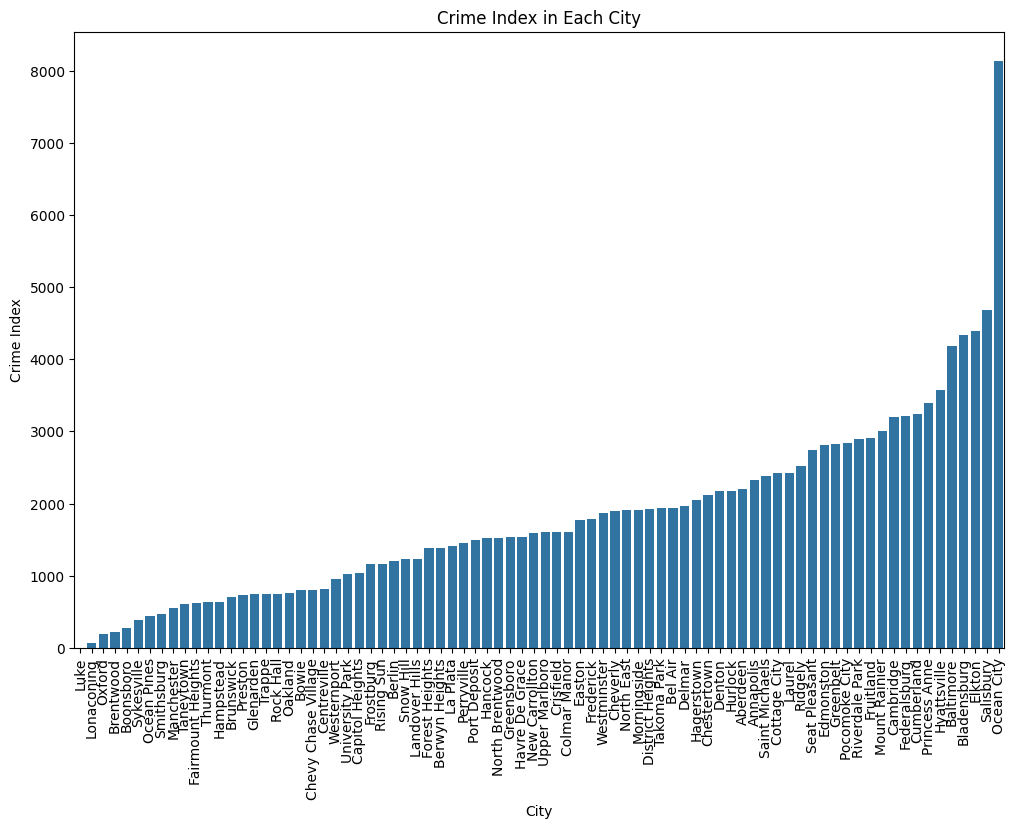

In [7]:
# Convert 'Crime Index ▲' to string first to safely replace commas and then convert to numeric
merged_df['Crime Index ▲'] = pd.to_numeric(merged_df['Crime Index ▲'].astype(str).str.replace(',', ''), errors='coerce')

# Now creating a bar graph for Crime Index in each city
plt.figure(figsize=(12, 8))
sns.barplot(x='City', y='Crime Index ▲', data=merged_df.sort_values('Crime Index ▲'))
plt.title('Crime Index in Each City')
plt.xlabel('City')
plt.ylabel('Crime Index')
plt.xticks(rotation=90)  # Rotate city names for better visibility
plt.show()

This graph here shows the number of crimes in each of the cities in Maryland. From this graph we can see that the highest crime city is Ocean city and the lowest is Luke. Some questions that we can think of are why does Ocean City have the highest crime index? What factors can lead to crime index being that high? You might have more questions too but for our project, we will use this graph and combine with the graph in the bottom to show which city is the best fit for you. 

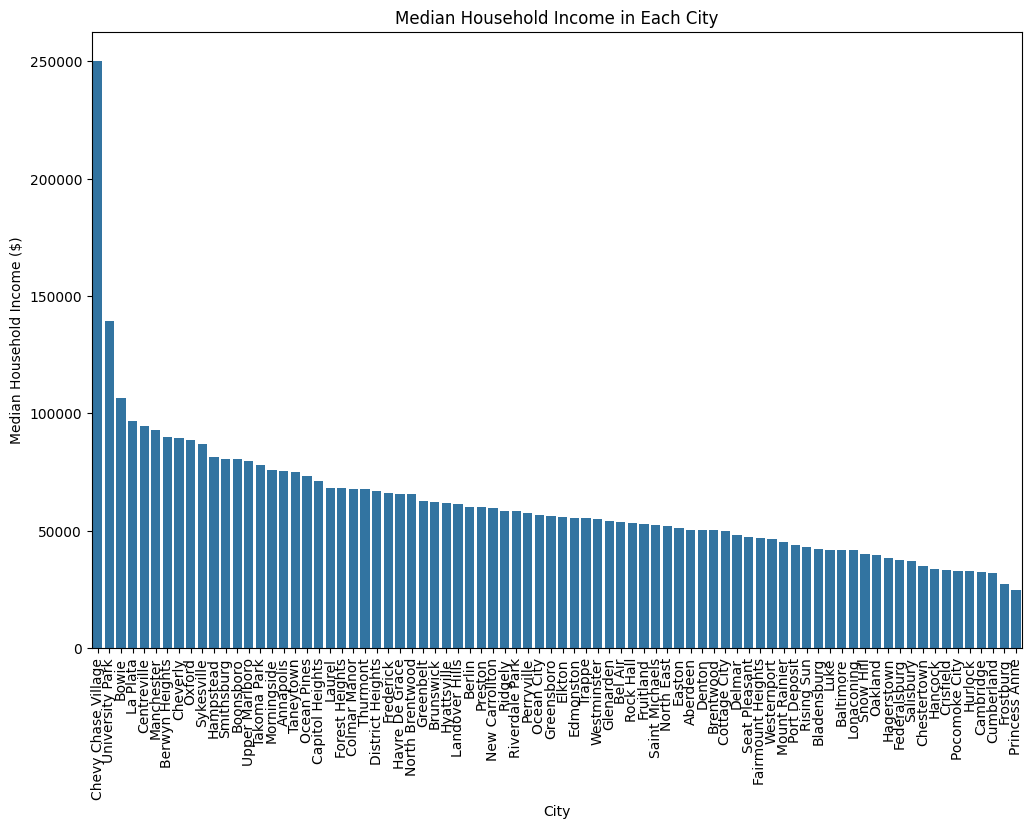

In [8]:
# Convert 'Median Household Income' to string, handle any commas, and convert to numeric
merged_df['Median Household Income'] = pd.to_numeric(merged_df['Median Household Income'].astype(str).str.replace(',', '').str.replace('$', ''), errors='coerce')

# Creating a bar graph for Median Household Income in each city
plt.figure(figsize=(12, 8))
sns.barplot(x='City', y='Median Household Income', data=merged_df.sort_values('Median Household Income', ascending=False))
plt.title('Median Household Income in Each City')
plt.xlabel('City')
plt.ylabel('Median Household Income ($)')
plt.xticks(rotation=90)  # Rotate city names for better visibility
plt.show()

This graph shows the median household incomes across various cities in Maryland, allowing viewers to compare income levels between locations. We will next show the graph of the Median House price in each city and comparing it to the median household income. 

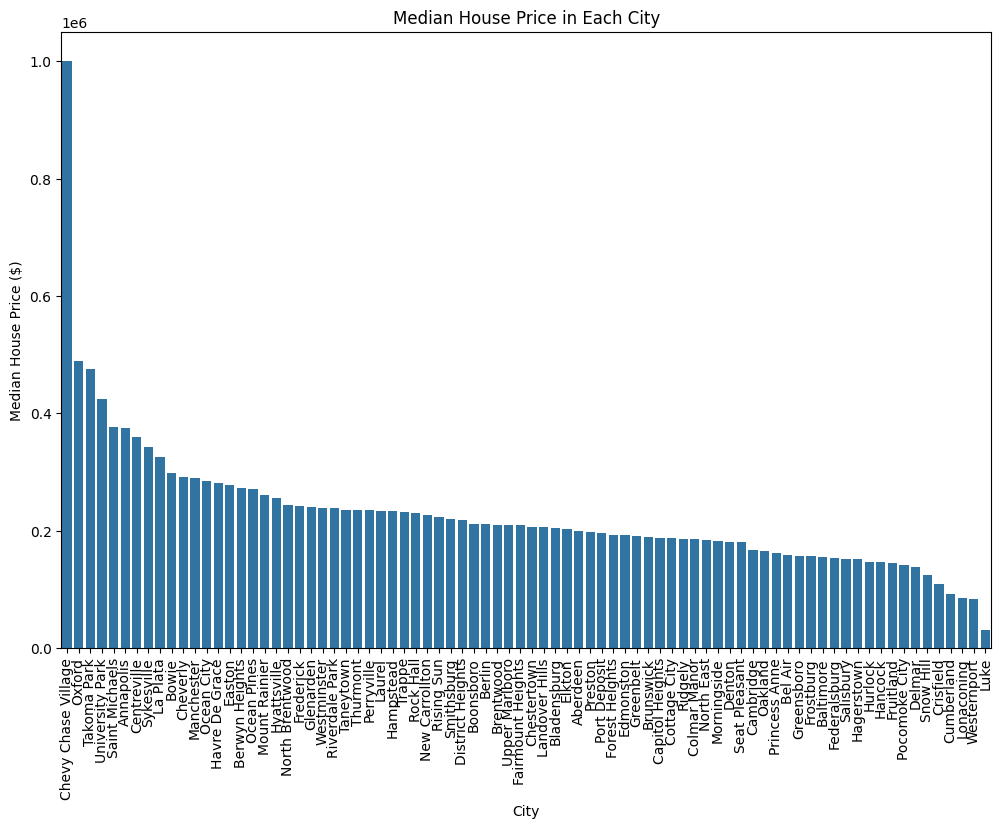

In [9]:
# Convert 'Median House Price' to string, handle any commas, and convert to numeric
merged_df['Median House Price'] = pd.to_numeric(merged_df['Median House Price'].astype(str).str.replace(',', '').str.replace('$', ''), errors='coerce')

# Creating a bar graph for Median House Price in each city
plt.figure(figsize=(12, 8))
sns.barplot(x='City', y='Median House Price', data=merged_df.sort_values('Median House Price', ascending=False))
plt.title('Median House Price in Each City')
plt.xlabel('City')
plt.ylabel('Median House Price ($)')
plt.xticks(rotation=90)  # Rotate city names for better visibility
plt.show()

This bar graph shows the median house prices in various cities across Maryland and is a very valuable tool for people seeking the perfect place to live in Maryland. By visually comparing the heights of the bars, people can decide a city that has house prices within their budget. Furthermore, looking at this graph and the graph above it can help improve people's decision-making by allowing them to prioritize cities based on their preferences for amenities, services, and overall quality of life by just looking at the average house prices and median income. Some people want to live in a rich city because they are used living in a rich area while others are not. 

In [10]:
# Standardizing the scales
scaler = StandardScaler()
features = ['Crime Index ▲', 'Median Household Income', 'Median House Price']
merged_df[features] = scaler.fit_transform(merged_df[features])

# Create a score by weighting features
weights = {'Crime Index ▲': -1, 'Median Household Income': 1, 'Median House Price': 1}
merged_df['Score'] = (merged_df['Crime Index ▲'] * weights['Crime Index ▲'] +
                      merged_df['Median Household Income'] * weights['Median Household Income'] +
                      merged_df['Median House Price'] * weights['Median House Price'])

# Sort cities by score
sorted_cities = merged_df.sort_values(by='Score', ascending=False)

# Print the top 10 cities
print("Top 10 cities to live in Maryland based on score:\n", sorted_cities[['City', 'Score']].head(10))

Top 10 cities to live in Maryland based on score:
                    City      Score
20  Chevy Chase Village  13.802439
23      University Park   4.952906
2                Oxford   4.425725
21          Centreville   3.032380
5            Sykesville   2.970669
19                Bowie   2.933485
8            Manchester   2.596514
50          Takoma Park   2.581763
32             La Plata   2.351018
6           Ocean Pines   1.846599


To calculate the best cities for us to live in Maryland, we first standardized the scales of the three factors that we are mainly talking about which is crime rate, household income, and median house price. Standardization ensures that each factor is on the same scale so we can compare them. Next, we assigned weights to each factor based on their importance in determining the best cities. In this case, we assigned a weight of -1 to the crime index because the lower the crime rate, the safer the city is, and a weight of 1 to both median household income and median house price. Then, we computed a score for each city by multiplying each standardized factor by its respective weight and summing them up. This score represents the overall attractiveness of each city based on the selected criteria. At the end, we sort the cities based on their scores in descending order to identify the top 10 cities for us to consider living in Maryland.

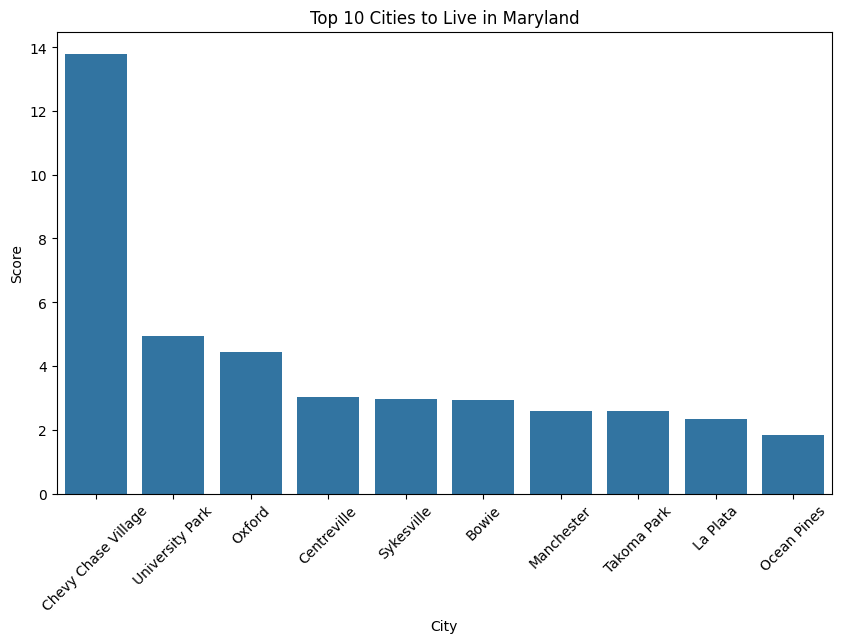

In [11]:
# Bar chart for the top 10 cities
top_cities = sorted_cities.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='City', y='Score', data=top_cities)
plt.title('Top 10 Cities to Live in Maryland')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Hypothesis Testing: Test if cities with high median household income have significantly different median house prices than others
# Define high income as being above the median income
median_income = merged_df['Median Household Income'].median()
high_income_cities = merged_df[merged_df['Median Household Income'] > median_income]
low_income_cities = merged_df[merged_df['Median Household Income'] <= median_income]

# Perform an independent t-test on house prices between high and low income cities
t_stat, p_value = stats.ttest_ind(high_income_cities['Median House Price'], low_income_cities['Median House Price'], nan_policy='omit')

print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Reject the null hypothesis - Significant differences exist between the house prices of high and low income cities.")
else:
    print("Do not reject the null hypothesis - No significant differences exist between the house prices of high and low income cities.")

T-statistic: 4.139183021992761, P-value: 8.741387629361139e-05
Reject the null hypothesis - Significant differences exist between the house prices of high and low income cities.


This code helps us figure out if cities with higher household incomes have noticeably different house prices compared to others. We split the cities into two groups, those with incomes above the median and those with incomes below the median. Next, we compare the median house prices between these two groups using a statistical test. If the p-value is less than 0.05, that means there's a significant difference in house prices between high and low income cities. This can give us a clue about how much our income level might affect the cost of housing in different places.

In [14]:
# Data cleaning and type conversion
# Ensure 'Population' is in integer format if necessary
if df['Population'].dtype == 'object':
    df['Population'] = df['Population'].str.replace(',', '').astype(int)

# Check if any additional data fields need cleaning or conversion
# Example: 'Median Household Income' and 'Median House Price' could be cleaned as shown previously
# df['Median Household Income'] = df['Median Household Income'].replace(r'[\$,]', '', regex=True).astype(int)
# df['Median House Price'] = df['Median House Price'].replace(r'[\$,]', '', regex=True).astype(int)

# Selecting features and target
X = df[['Population']]  # Adjust this if additional clean features are available
y = df['Crime Index ▲']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initializing the model
model = LinearRegression()

# Fitting the model on the training data
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Displaying coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Use statsmodels to get a detailed summary for p-values
X2 = sm.add_constant(X)  # adding a constant to the features
model_stats = sm.OLS(y, X2).fit()  # fitting the model
print(model_stats.summary())

Mean Squared Error: 974845.724728581
R^2 Score: -0.17585401917132315
            Coefficient
Population   286.805458
                            OLS Regression Results                            
Dep. Variable:          Crime Index ▲   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.766
Date:                Fri, 10 May 2024   Prob (F-statistic):             0.0320
Time:                        12:20:43   Log-Likelihood:                -683.31
No. Observations:                  80   AIC:                             1371.
Df Residuals:                      78   BIC:                             1375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

This partcan tell us which city in Maryland might be the best fit for you to live in. We start by ensuring that the data, such as population and crime index, is clean and ready for analysis. Then, we focus on population size as a factor to consider. We train a model to see if there's a link between a city's population and its crime rate. By examining metrics like mean squared error and R-squared, we can get an idea of how accurately our model predicts crime based on population size. This analysis helps us understand if there's a connection between the number of people living in a city and its crime levels. Additionally, the code reveals the coefficients, showing us the extent to which population size influences crime rates. 